In [1]:
import os.path as op

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import somato
from mne.baseline import rescale
from mne.stats import bootstrap_confidence_interval
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler

import torch
import torch.nn as nn
import torchvision.transforms
import matplotlib.pyplot as plt

from collections import OrderedDict
from pylab import rcParams


In [2]:
data_path = somato.data_path()
subject = '01'
task = 'somato'
event_id, tmin, tmax = 1, -1., 3.
baseline = None
raw_fname = op.join(data_path, 'sub-{}'.format(subject), 'meg',
                    'sub-{}_task-{}_meg.fif'.format(subject, task))

# let's explore some frequency bands
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [3]:
# Apply machine learning: Classify it's alpha or beta.
# Alpha : class 0
# Beta : class 1
alpha_freq = iter_freqs[1]
raw = mne.io.read_raw_fif(raw_fname)
events = mne.find_events(raw, stim_channel='STI 014')
raw.pick_types(meg='grad', eeg=True, eog=False)  
raw.load_data()

 # bandpass filter for alpha
raw.filter(alpha_freq[1], alpha_freq[2], n_jobs=1,  # use more jobs to speed up.
             l_trans_bandwidth=1,  # make sure filter params are the same
              h_trans_bandwidth=1)  # in each band and skip "auto" option.

# epoch with alpha data.
epochs_alpha = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline,
                        reject=dict(grad=4000e-13),
                        preload=True)
# remove evoked response
epochs_alpha.subtract_evoked()

del raw

beta_freq = iter_freqs[2]
raw = mne.io.read_raw_fif(raw_fname)
events = mne.find_events(raw, stim_channel='STI 014')
raw.pick_types(meg='grad', eeg=True, eog=False)  
raw.load_data()

# bandpass filter for beta
raw.filter(beta_freq[1], beta_freq[2], n_jobs=1,  # use more jobs to speed up.
             l_trans_bandwidth=1,  # make sure filter params are the same
              h_trans_bandwidth=1)  # in each band and skip "auto" option.

# epoch with beta data.
epochs_beta = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline,
                        reject=dict(grad=4000e-13),
                        preload=True)

# remove evoked response
epochs_beta.subtract_evoked()

del raw

Opening raw data file /Users/wakkihaya/mne_data/MNE-somato-data/sub-01/meg/sub-01_task-somato_meg.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.
111 events found
Event IDs: [1]
Reading 0 ... 269399  =      0.000 ...   897.077 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 993 samples (3.307 sec)

Not setting metadata
Not setting metadata
111 matching events found
No baseline correction applied
0 projection items activated
Loading data for 111 events and 1202 original t

In [4]:
alpha_data=epochs_alpha.get_data() #[n_epochs, n_channels, n_times]
beta_data=epochs_beta.get_data()
class0 = np.zeros((alpha_data.shape[0],1))
class1 = np.ones((beta_data.shape[0],1))
alpha_data=alpha_data.reshape(len(class0), -1)
beta_data= beta_data.reshape(len(class1), -1)

In [5]:
X = np.concatenate((alpha_data,beta_data), axis= 0)
y = np.concatenate((class0, class1), axis =0)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()

In [7]:
# Make CNN Model
cnn = nn.Sequential()

# Input Layer (Size 226 -> 500)
cnn.add_module('Input Linear', nn.Linear(245208, 500))
cnn.add_module('Input Activation', nn.CELU()) 

# Hidden Layer (Size 500 -> 1000)
cnn.add_module('Hidden Linear', nn.Linear(500, 1000))
cnn.add_module('Hidden Activation', nn.ReLU())

# Hidden Layer (Size 1000 -> 100)
cnn.add_module('Hidden Linear2', nn.Linear(1000, 100))
cnn.add_module('Hidden Activation2', nn.ReLU())

# Hidden Layer (Size 100 -> 10)
cnn.add_module('Hidden Linear3', nn.Linear(100, 10))
cnn.add_module('Hidden Activation3', nn.ReLU())

# Output Layer (Size 10 -> 1)
cnn.add_module('Output Linear', nn.Linear(10, 1))
cnn.add_module('Output Activation', nn.Sigmoid())

In [22]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [23]:
#TODO: Compare input array shape for CNN model
# TODO: What is number of classes for output?

# Define a loss function
loss_function = torch.nn.MSELoss()

# Define a training procedure
def train_network(train_data, actual_class, iterations):

  # Keep track of loss at every training iteration
  loss_data = []
  acc_data = []

  # Begin training for a certain amount of iterations
  for i in range(iterations):

    # Begin with a classification
    classification = cnn(train_data)

    # Find out how wrong the network was
    loss = loss_function(classification, actual_class)
    loss_data.append(loss)

    # Zero out the optimizer gradients every iteration
    optimizer.zero_grad()

    # Teach the network how to do better next time
    loss.backward()
    optimizer.step()
    
    acc = accuracy(classification, actual_class)
    acc_data.append(acc)
  
  # Plot a nice loss graph at the end of training
  rcParams['figure.figsize'] = 10, 5
  plt.title("Loss vs Iterations")
  plt.plot(list(range(0, len(loss_data))), loss_data)
  plt.show()
    
 # Plot accucacy
  rcParams['figure.figsize'] = 10, 5
  plt.title("Accuracy vs Iterations")
  plt.plot(list(range(0, len(acc_data))), acc_data)
  plt.show()


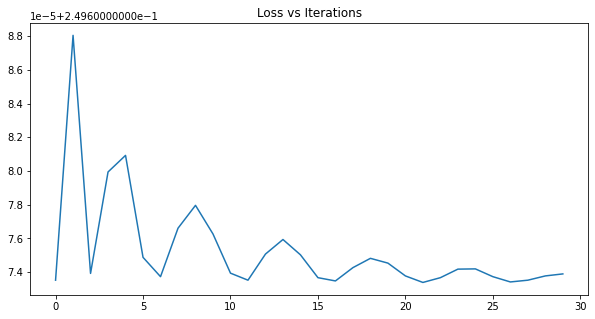

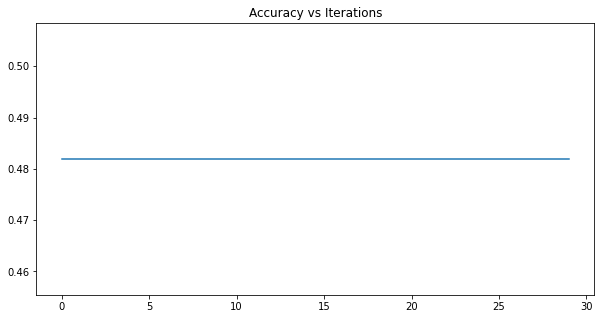

In [24]:
# Define a learning function, needs to be reinitialized every load
optimizer = torch.optim.Adam(cnn.parameters(), lr =1e-3)
train_network(X_train, y_train, iterations = 30)

In [19]:
# TODO: how to put accuracty output.


[[0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]
 [0.51840967]]
[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]

ValueError: Classification metrics can't handle a mix of continuous and binary targets